In [39]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

#from rhlUtils import imshow, makePsf

#%matplotlib notebook 
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

dataDir = ""

Read the data.  There are three items in the pickle:

- The data (a dict indexed by "fiberId" containing numpy arrays):
 - pixelPos           Measured centroid of an arc line (pixels)
 - pixelPosErr        Error in pixelPos
 - refWavelength      Nominal wavelength (from NIST)
 - modelFitWavelength Wavelength corresponding to pixelPos, based on instrument model
 - status             bitwise OR of flags (see statusFlags)
- A dict giving the meaning of the status bits
- An linear approximation to the wavelength solution:  wavelength = wavelength0 + nmPerPix*i

In [72]:
import pickle

with open(os.path.join(dataDir, "arclines.pickle"), "rb") as fd:
    data, statusFlags, (wavelength0, nmPerPix) = pickle.load(fd)

Plot some of the data.  A good place to start would be the pixel position (pixelPos) and the reference wavelength (refWavelength) for a fibre, then use wavelength0 and nmPerPix to construct an approximate (linear) wavelength solution and look at the residuals.

[ 0.07731503  0.05815182  0.04410543  0.04041687  0.0487168   0.0452336
  0.17058022  0.03778351  0.04111109  0.03007881  0.          0.10178081
  0.04618985  0.02520729  0.03973202  0.12198777  0.06278301  0.06460614
  0.0800623   0.10628096  0.08651872  0.13411245  0.08673394  0.13924013
  0.11291998  0.07218608  0.12141118  0.12699461  0.16451703  0.05418658
  0.15353394  0.14865039  0.07293121  0.07154124  0.12819505  0.07456884
  0.1414192   0.11552315  0.07856612  0.09017812  0.11458386  0.1662529
  0.10523336  0.11593409  0.19834183  0.11931082  0.12520254  0.18447748
  0.13882938  0.17094399  0.16339366  0.1448977   0.19247676  0.15706715]


<IPython.core.display.Javascript object>


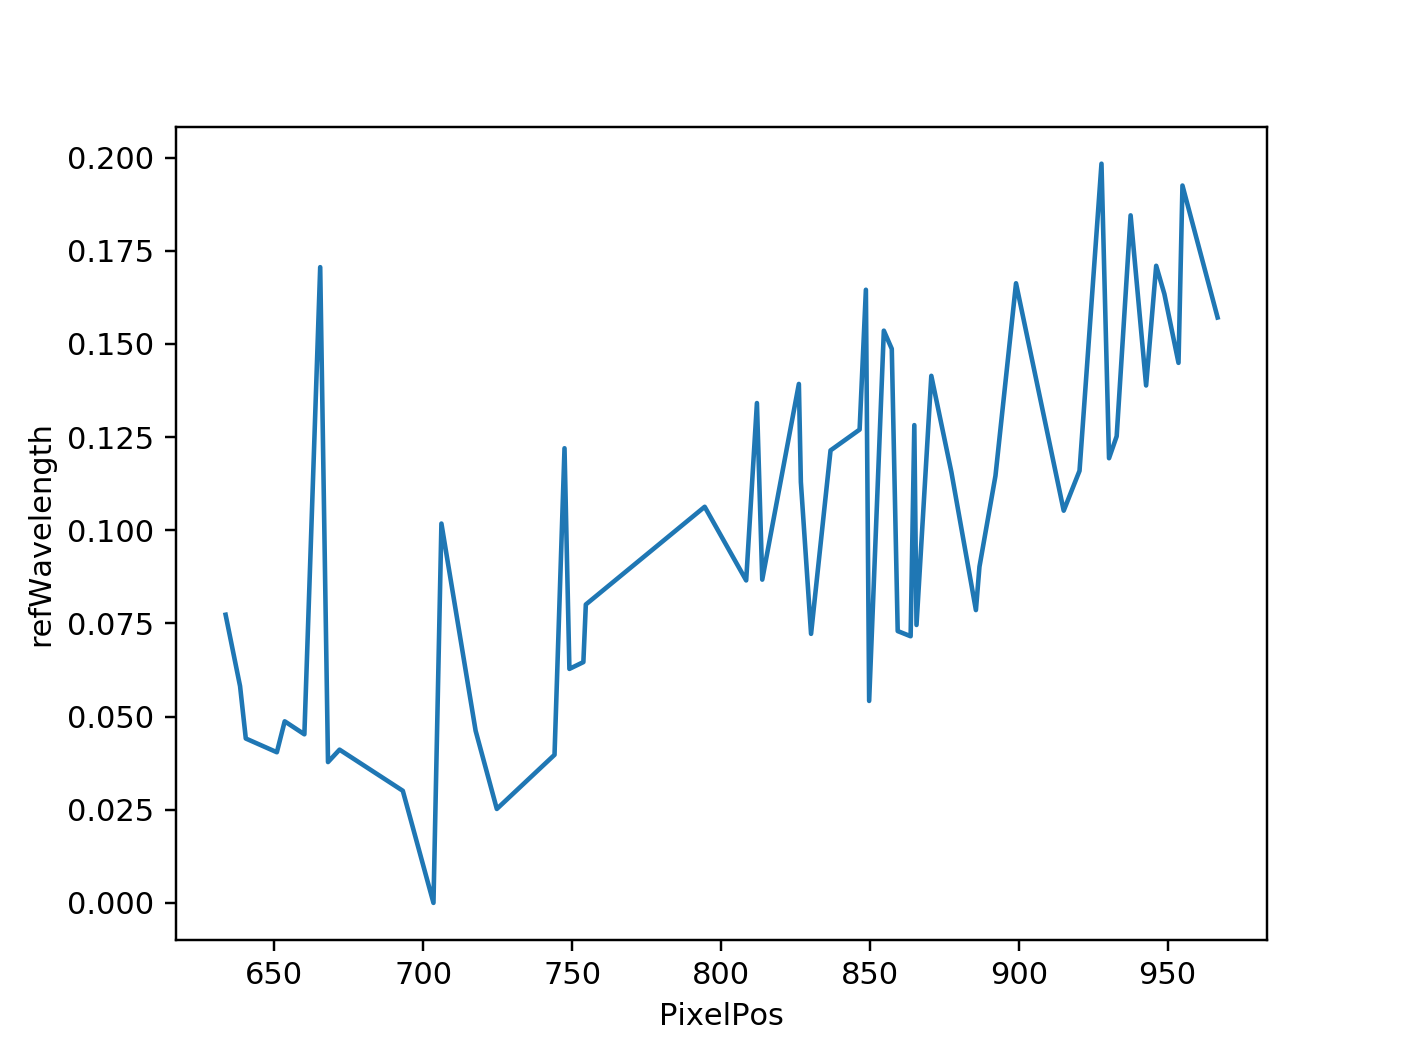

In [75]:
fiberId = 5
assert fiberId in data, "Unknown fiberId: %d" % fiberId
pixelPos = data[5]['pixelPos']
pixelPoserr = data[5]['pixelPosErr']
refWave = data[5]['refWavelength']
print(pixelPoserr)
plt.errorbar(refWave,pixelPoserr)
plt.xlabel('PixelPos')
plt.ylabel('refWavelength')


# ...

Take a look at the statusFlags and the values of status from your fibre.  You probably want to ignore some of the data (Hint: I muttered about bad lines in the lecture)

In [45]:
stat = data[5]['status']
print(statusFlags)
print(stat)
print(len(stat), len(pixelPos))
good=np.where(stat==1)
stat=stat[good]
pixelPos=pixelPos[good]
refWave= refWave[good]
print(stat)
print(pixelPos)

plt.plot(pixelPos,refWave)
plt.xlabel('PixelPos')
plt.ylabel('refWavelength')

{'FIT': 1, 'RESERVED': 2, 'SATURATED': 16, 'CR': 64, 'MISIDENTIFIED': 4, 'CLIPPED': 8}
[  1   1   1   1   1   1   1   1   1  49 112   1   1  49   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1]
54 54
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[  137.5663147    193.48243713   215.64245605   335.57107544   365.88891602
   441.81820679   502.8387146    532.92498779   577.44696045   970.4039917
  1102.35534668  1407.3927002   1446.03283691  1464.98632812  1519.10620117
  1528.63330078  1990.54211426  2152.37182617  2194.40063477  2215.19824219
  2358.61181641  2366.62353516  2406.57788086  2483.00756836  2597.39013672
  2622.26367188  2634.9609375   2692.93408203  2724.3828125   2747.71166992
  2798.83129883  2813.52197266  2822.15258789  2880.79907227  2960.56665039
  3057.9609375   3071.99755859  3135.88891602  3218

Let's concentrate on just one fiber for now; choose a fibre, any fibre.  We want to fit a better model of the wavelength solution.  The CCD has 4096 rows, and we want a solution valid over all of them.

Experiment with a range of order of fitter, and look at the rms error in the wavelength solution.  You can look at $\chi^2/\nu$ too, if you like, but I think you'll find that the centroiding errors are wrong.

You probably want to look at the fit and at the residuals from the fit.

[-9143.2587018   5486.42945647 -9641.83109792]


<IPython.core.display.Javascript object>


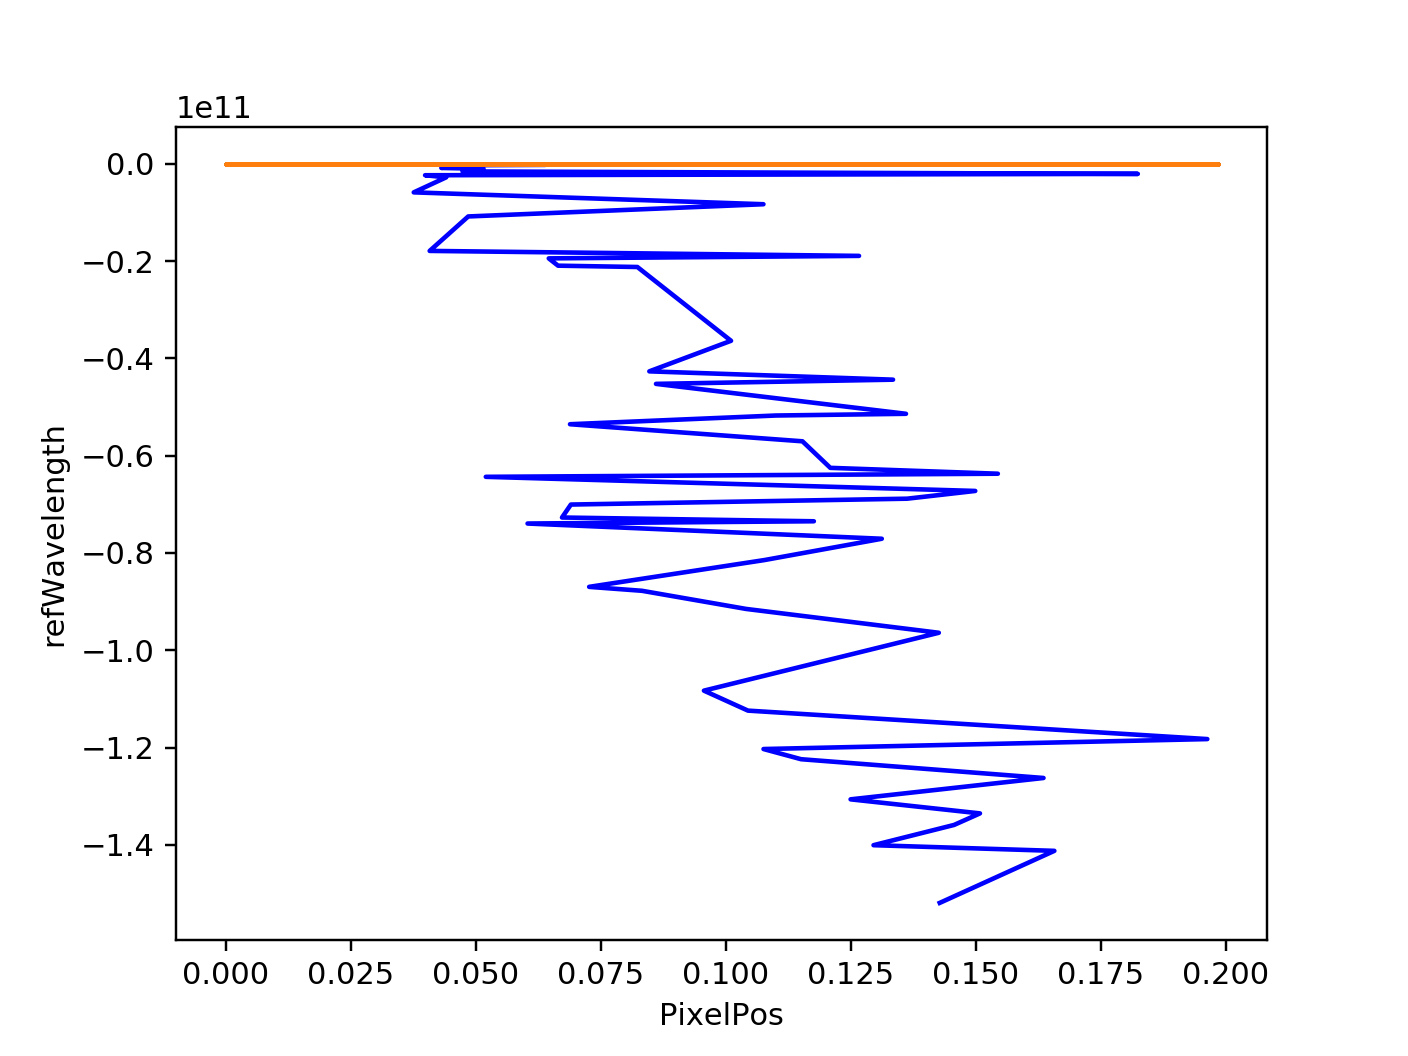

In [70]:
import numpy.polynomial.chebyshev as cheb
myFiberId = 315

pixelPos = data[myFiberId]['pixelPos']
pixelPoserr = data[myFiberId]['pixelPosErr']
refWave = data[myFiberId]['refWavelength']
stat = data[myFiberId]['status']

good=np.where(stat==1)
stat=stat[good]
pixelPos=pixelPos[good]
refWave= refWave[good]
pixelPoserr=pixelPoserr[good]

nrow = 4096
fitOrder = 2

fit2=cheb.chebfit(pixelPoserr, refWave, deg=fitOrder)
print(fit2)
linefit=fit2[0] + fit2[1]*pixelPos + fit2[2]*(pixelPos**2)

#xp = np.linspace(0, 4000, len(pixelPos))

plt.errorbar(pixelPoserr,refWave,yerr=pixelPoserr,color="red")
plt.plot(pixelPoserr, linefit, '-',color="blue")
plt.xlabel('PixelPos')
plt.ylabel('refWavelength')

Now repeat the preceeding exercise using the model of the spectrograph (i.e. the modelFitWavelength not your linear approximation).  What order of polynomial is needed now?

Is that rms error honest, or are we overfitting?  Modify your code to hold back some number of arclines from the fit and measure the rms only of those ones.

If this was all

I was nice and gave you clean (but real) data.  In the real world you'd probably want to do an n-sigma clip on the residuals and iterate.  Implement this.